# Geekbrains AI/BigData Python for Data Science course competition
https://www.kaggle.com/c/realestatepriceprediction/leaderboard

#### Files description
train.csv - the training set  
test.csv - the test set

#### Data fields
**Id** - идентификационный номер квартиры   
**DistrictId** - идентификационный номер района   
**Rooms** - количество комнат   
**Square** - площадь   
**LifeSquare** - жилая площадь   
**KitchenSquare** - площадь кухни   
**Floor** - этаж   
**HouseFloor** - количество этажей в доме   
**HouseYear** - год постройки дома   
**Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности   
**Social_1, Social_2, Social_3** - социальные показатели местности   
**Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья   
**Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров   
**Price** - цена квартиры

#### Импорт библиотек

In [1]:
import os
import time
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.cluster import DBSCAN

import missingno as msno
import xgboost as xgb
import catboost as cb

import warnings
warnings.filterwarnings('ignore')

#### Функции

In [2]:
def get_input(data_path):
    '''
    Читаем данные из файла,
    приводим названия колонок к нижнему регистру, 
    выводим размеры датасетов
    '''
    data = pd.read_csv(data_path)
    data.columns = data.columns.str.lower()
    print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")
    return data


def get_numerical_features(df):
    """
    Список числовых признаков датасета
    """
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"Количество числовых признаков: {len(numerical_features)}")
    return numerical_features


def catboost_cross_validation(params, X, y, cv, categorical=None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
#     X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostRegressor(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict(x_valid)
        score = r2_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 4)}")
        folds_scores.append(round(score, 4))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    print(f"{r2_score(y, oof_preds)}")
    return estimators, oof_preds

In [3]:
def prepare_dataset(X: pd.DataFrame, todrop: list, copy: bool=True) -> pd.DataFrame:
    """
    Выделение групп признаков, удаление выбросов, создание новых признаков.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков исходного датасета.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков, готовая к обучению/предикту.

    """
    if copy:
        X = X.copy()

    target = 'price'
    
    X = X.drop(columns=todrop)
    
    # Списки признаков
#     num_feats = X.select_dtypes(include=[np.number]).columns.tolist()
#     cat_feats = X.select_dtypes(include=[np.object]).columns.tolist()
#     discr_feats = [feature for feature in num_feats if len(X[feature].unique()) < 25] + ["districtid"]
#     X[discr_feats] = X[discr_feats].astype(np.int)
    
    X.loc[X['rooms'] == 0, 'rooms'] = 2
    X.loc[X['rooms'] > 5, 'rooms'] = 2
    
    X.loc[X['floor'] > 50, 'floor'] = X['floor'].median()
    X.loc[X['housefloor'] > 50, 'housefloor'] = X['housefloor'].median()
    
#     X.loc[X['lifesquare'] > 1000, 'lifesquare'] = X.loc[X['lifesquare'] > 1000, 'lifesquare'] / 100
#     X.loc[X['lifesquare'] > 250, 'lifesquare'] = X.loc[X['lifesquare'] > 250, 'lifesquare'] / 10
#     X.loc[X['lifesquare'] > 250, 'lifesquare'] = X['lifesquare'].median()

    X.loc[X['kitchensquare'] > 50, 'kitchensquare'] = X['kitchensquare'].median()
    
    X['squ_rooms'] = X['square'] / X['rooms']
    X['squ_kitch'] = X['square'] / X['kitchensquare']
    X['sum_cat'] = X['ecology_2'] + X['ecology_3'] +  X['shops_2']
    
    X = X.drop(columns=['lifesquare'])
    return X


#### Загрузка данных

In [4]:
path = 'data'
os.listdir(path)

['test.csv', 'train.csv']

In [5]:
train = get_input(f'{path}/train.csv')
test = get_input(f'{path}/test.csv')

data/train.csv: shape = 10000 rows, 20 cols
data/test.csv: shape = 5000 rows, 19 cols


## Data EDA

In [6]:
train.head(2)

,id,districtid,rooms,square,lifesquare,kitchensquare,floor,housefloor,houseyear,ecology_1,ecology_2,ecology_3,social_1,social_2,social_3,healthcare_1,helthcare_2,shops_1,shops_2,price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.08904,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.00007,B,B,46,10309,1,240.0,1,16,B,300009.450063


In [7]:
test.head(2)

,id,districtid,rooms,square,lifesquare,kitchensquare,floor,housefloor,houseyear,ecology_1,ecology_2,ecology_3,social_1,social_2,social_3,healthcare_1,helthcare_2,shops_1,shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B


#### Основные статистики

In [8]:
train.describe()

,id,districtid,rooms,square,lifesquare,kitchensquare,floor,housefloor,houseyear,ecology_1,social_1,social_2,social_3,healthcare_1,helthcare_2,shops_1,price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [9]:
test.describe()

,id,districtid,rooms,square,lifesquare,kitchensquare,floor,housefloor,houseyear,ecology_1,social_1,social_2,social_3,healthcare_1,helthcare_2,shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


### Анализ числовых признаков

In [10]:
numerical_features = get_numerical_features(train)
numerical_features

Количество числовых признаков: 17


['id',
 'districtid',
 'rooms',
 'square',
 'lifesquare',
 'kitchensquare',
 'floor',
 'housefloor',
 'houseyear',
 'ecology_1',
 'social_1',
 'social_2',
 'social_3',
 'healthcare_1',
 'helthcare_2',
 'shops_1',
 'price']

#### Выделим целевую переменную

In [11]:
target = 'price'

In [12]:
numerical_features = list(set(numerical_features) - set([target, 'id']))

#### Плотность распределения целевой переменной

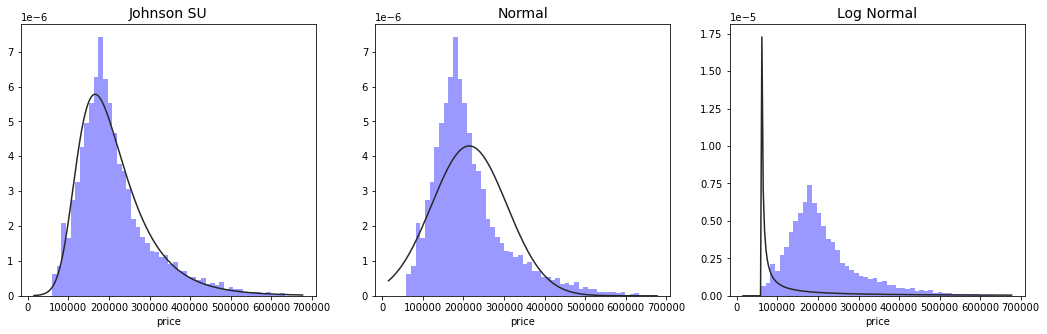

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].set_title("Johnson SU", fontsize=14)
sns.distplot(train[target], kde=False, color="blue", fit=st.johnsonsu, ax=axes[0])

axes[1].set_title("Normal", fontsize=14)
sns.distplot(train[target], kde=False, color="blue", fit=st.norm, ax=axes[1])

axes[2].set_title("Log Normal", fontsize=14)
sns.distplot(train[target], kde=False, color="blue", fit=st.lognorm, ax=axes[2])
plt.show()

#### Переменные, связанные со временем

In [14]:
print(f'уникальных значений: {train["houseyear"].nunique()}')
train['houseyear'].unique()

уникальных значений: 97


array([    1969,     1978,     1968,     1977,     1976,     2011,
           1960,     2014,     1973,     1959,     1999,     1980,
           1979,     1983,     2001,     2012,     2002,     1996,
           1964,     2018,     1972,     1965,     1984,     1961,
           1971,     1963,     2017,     1970,     1981,     2003,
           2016,     1991,     1975,     2006,     2009,     1985,
           1974,     1994,     2000,     1987,     1998,     2005,
           1990,     1982,     1997,     2015,     2008,     2010,
           2004,     2007,     1967,     1957,     1962,     1993,
           1966,     1955,     1937,     1992,     1954,     1995,
           2019,     1948,     1986,     2013,     1989,     1958,
           1938,     1956,     1988,     2020,     1951,     1952,
           1935,     1914,     1932,     1950,     1917,     1918,
           1940, 20052011,     1942,     1939,     1934,     1931,
           1919,     1912,     1953,     1936,     1947,     1

In [15]:
print(f'уникальных значений: {test["houseyear"].nunique()}')
test['houseyear'].unique()

уникальных значений: 97


array([1972, 1977, 1909, 2007, 2017, 1997, 2014, 1981, 1971, 1968, 1974,
       1959, 1976, 2015, 2004, 2000, 1970, 1964, 1975, 1988, 1963, 1987,
       1933, 1962, 1969, 1984, 1980, 1929, 1990, 1960, 2016, 1954, 1996,
       2019, 1993, 1911, 1985, 1982, 1966, 1978, 2003, 1983, 1973, 2018,
       2013, 2010, 1957, 1958, 1965, 2008, 1986, 1979, 2012, 1995, 1999,
       1989, 1992, 2009, 1956, 2005, 1998, 1940, 2002, 1991, 1967, 1994,
       2020, 1955, 1961, 2006, 2011, 1926, 2001, 1934, 1917, 1931, 1953,
       1943, 1941, 1930, 1912, 1935, 1927, 1937, 1918, 1950, 1952, 1910,
       1939, 1914, 1908, 1938, 1928, 1932, 1948, 1949, 1920], dtype=int64)

In [16]:
set(train['houseyear'].unique()) - set(test['houseyear'].unique())

{1916, 1919, 1936, 1942, 1947, 1951, 4968, 20052011}

In [17]:
set(test['houseyear'].unique()) - set(train['houseyear'].unique())

{1908, 1909, 1911, 1920, 1926, 1927, 1943, 1949}

4968, 20052011 - это явные опечатки, исправим их

In [18]:
train.loc[train["houseyear"] == 4968, 'houseyear'] = 1968
train.loc[train["houseyear"] == 20052011, 'houseyear'] = 2005

Text(0.5, 0, 'houseyear')

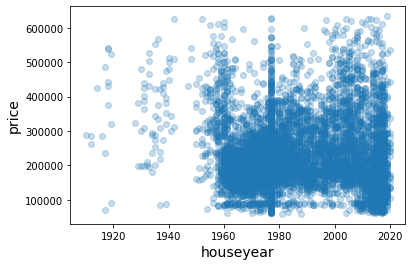

In [19]:
plt.scatter(x=train["houseyear"], y=train["price"], alpha=0.25)
plt.ylabel("price", size=14)
plt.xlabel("houseyear", size=14)

Явной зависимости стоимости жилья от гда постройки не наблюдается.

#### Дискретные признаки

In [20]:
discrete_feature = [
    feature for feature in numerical_features
    if len(train[feature].unique()) < 50
] + ["districtid"] + ["houseyear"]

print(f"Discrete Variables Count: {len(discrete_feature)}")
discrete_feature

Discrete Variables Count: 8


['shops_1',
 'rooms',
 'housefloor',
 'social_3',
 'floor',
 'helthcare_2',
 'districtid',
 'houseyear']

In [21]:
train[discrete_feature] = train[discrete_feature].astype('int')
test[discrete_feature] = test[discrete_feature].astype('int')

#### Категориальные признаки

In [22]:
categorical_features = train.select_dtypes(include=[np.object]).columns.tolist()
print(f"Categorical Feature Count: {len(categorical_features)}")
categorical_features

Categorical Feature Count: 3


['ecology_2', 'ecology_3', 'shops_2']

In [23]:
train['ecology_2'].value_counts()

B    9903
A      97
Name: ecology_2, dtype: int64

In [24]:
train['ecology_2'] = (train['ecology_2'] == 'A').astype(int)
train['ecology_3'] = (train['ecology_3'] == 'A').astype(int)
train['shops_2'] = (train['shops_2'] == 'A').astype(int)
test['ecology_2'] = (test['ecology_2'] == 'A').astype(int)
test['ecology_3'] = (test['ecology_3'] == 'A').astype(int)
test['shops_2'] = (test['shops_2'] == 'A').astype(int)

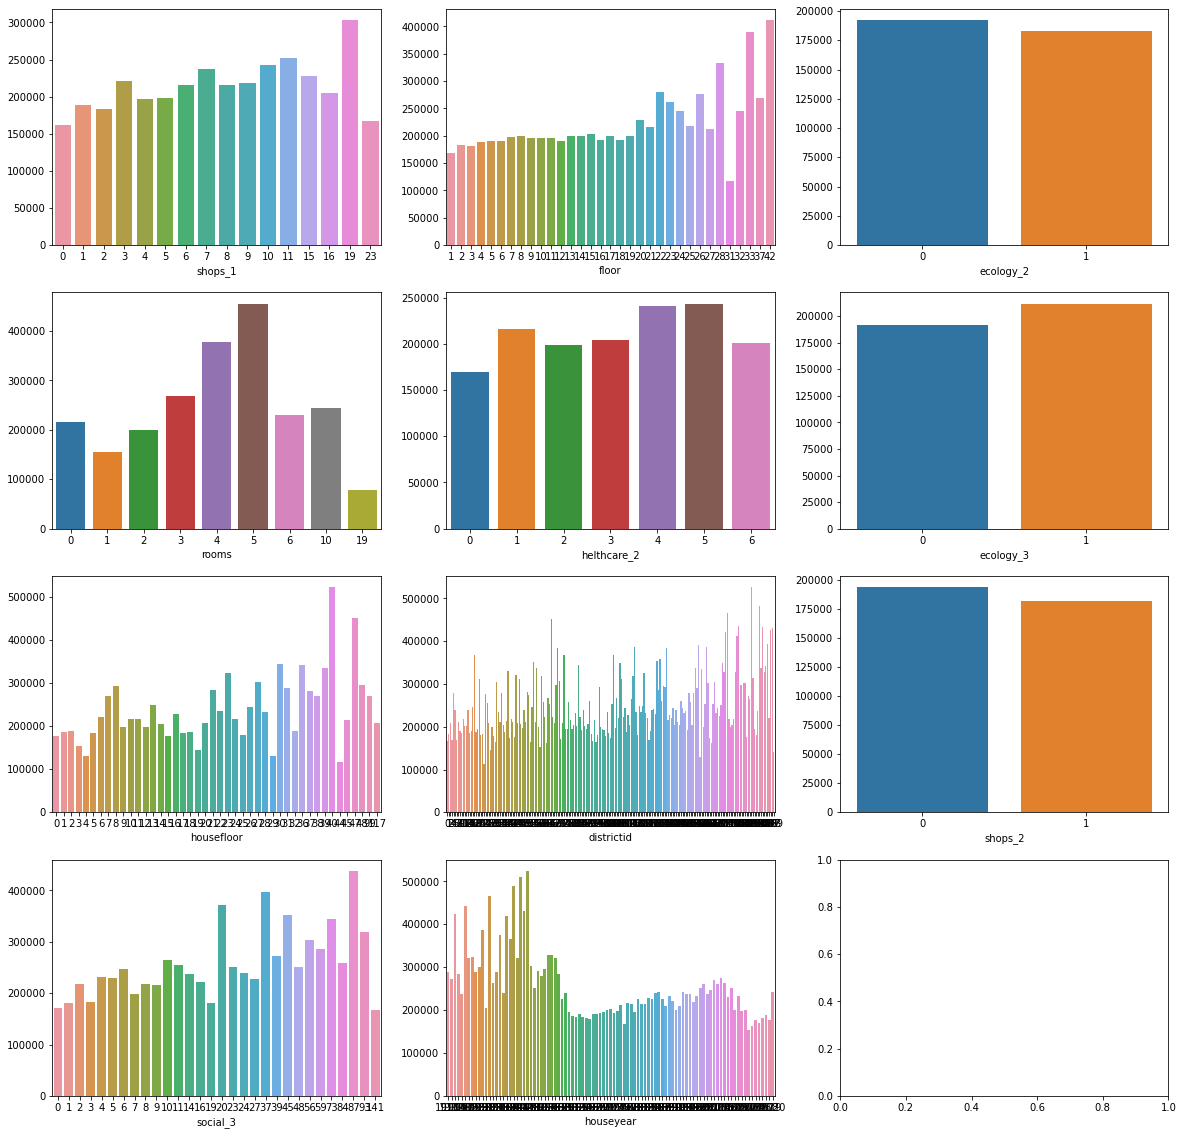

In [25]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

for num, feature in enumerate(discrete_feature + categorical_features):
    data = train.copy()
    statistics = data.groupby([feature])["price"].median()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        ax=axes[num%4, num//4]
    )

#### Непрерывные признаки

In [26]:
continuous_feature = [
    feature for feature in numerical_features
    if feature not in discrete_feature]

print(f"Continuous Feature Count {len(continuous_feature)}")
continuous_feature

Continuous Feature Count 7


['healthcare_1',
 'square',
 'social_1',
 'kitchensquare',
 'social_2',
 'ecology_1',
 'lifesquare']

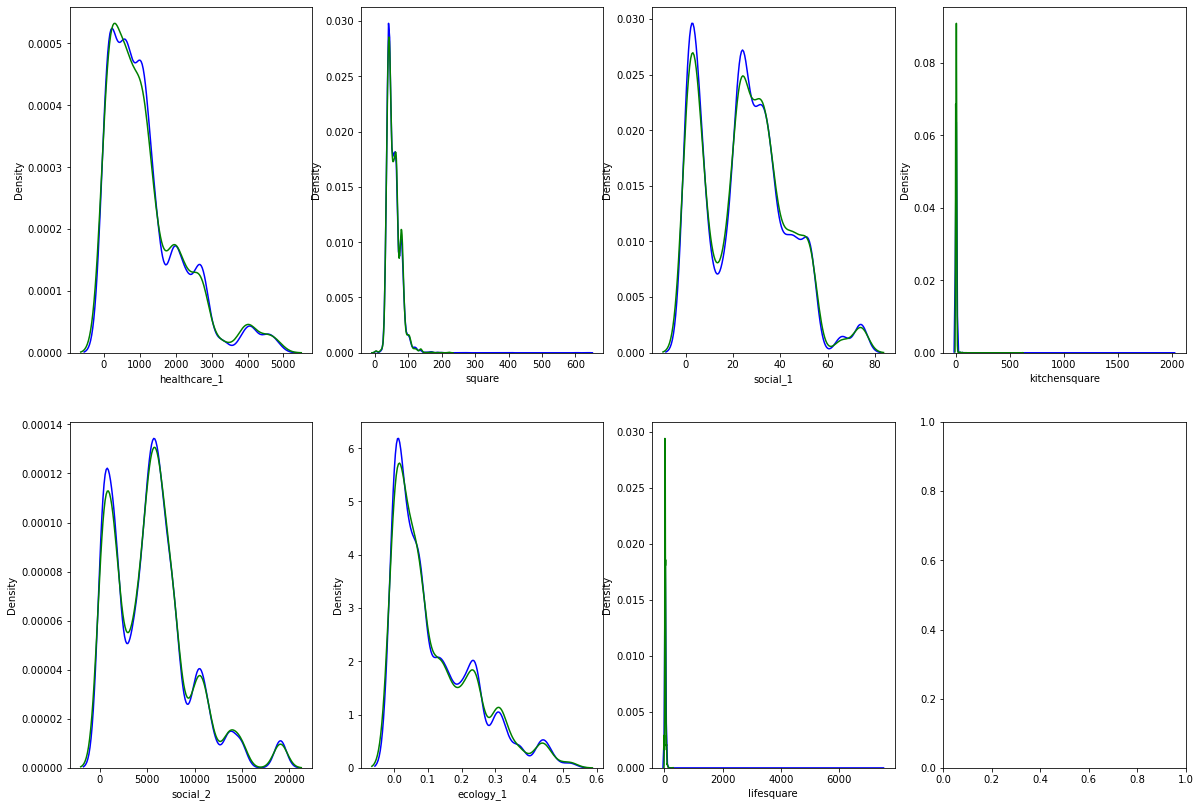

In [27]:
fig, axes = plt.subplots(2, 4, figsize=(20, 14))

for num, feature in enumerate(continuous_feature):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")

Распределения признаков в трейне и тесте различаются.

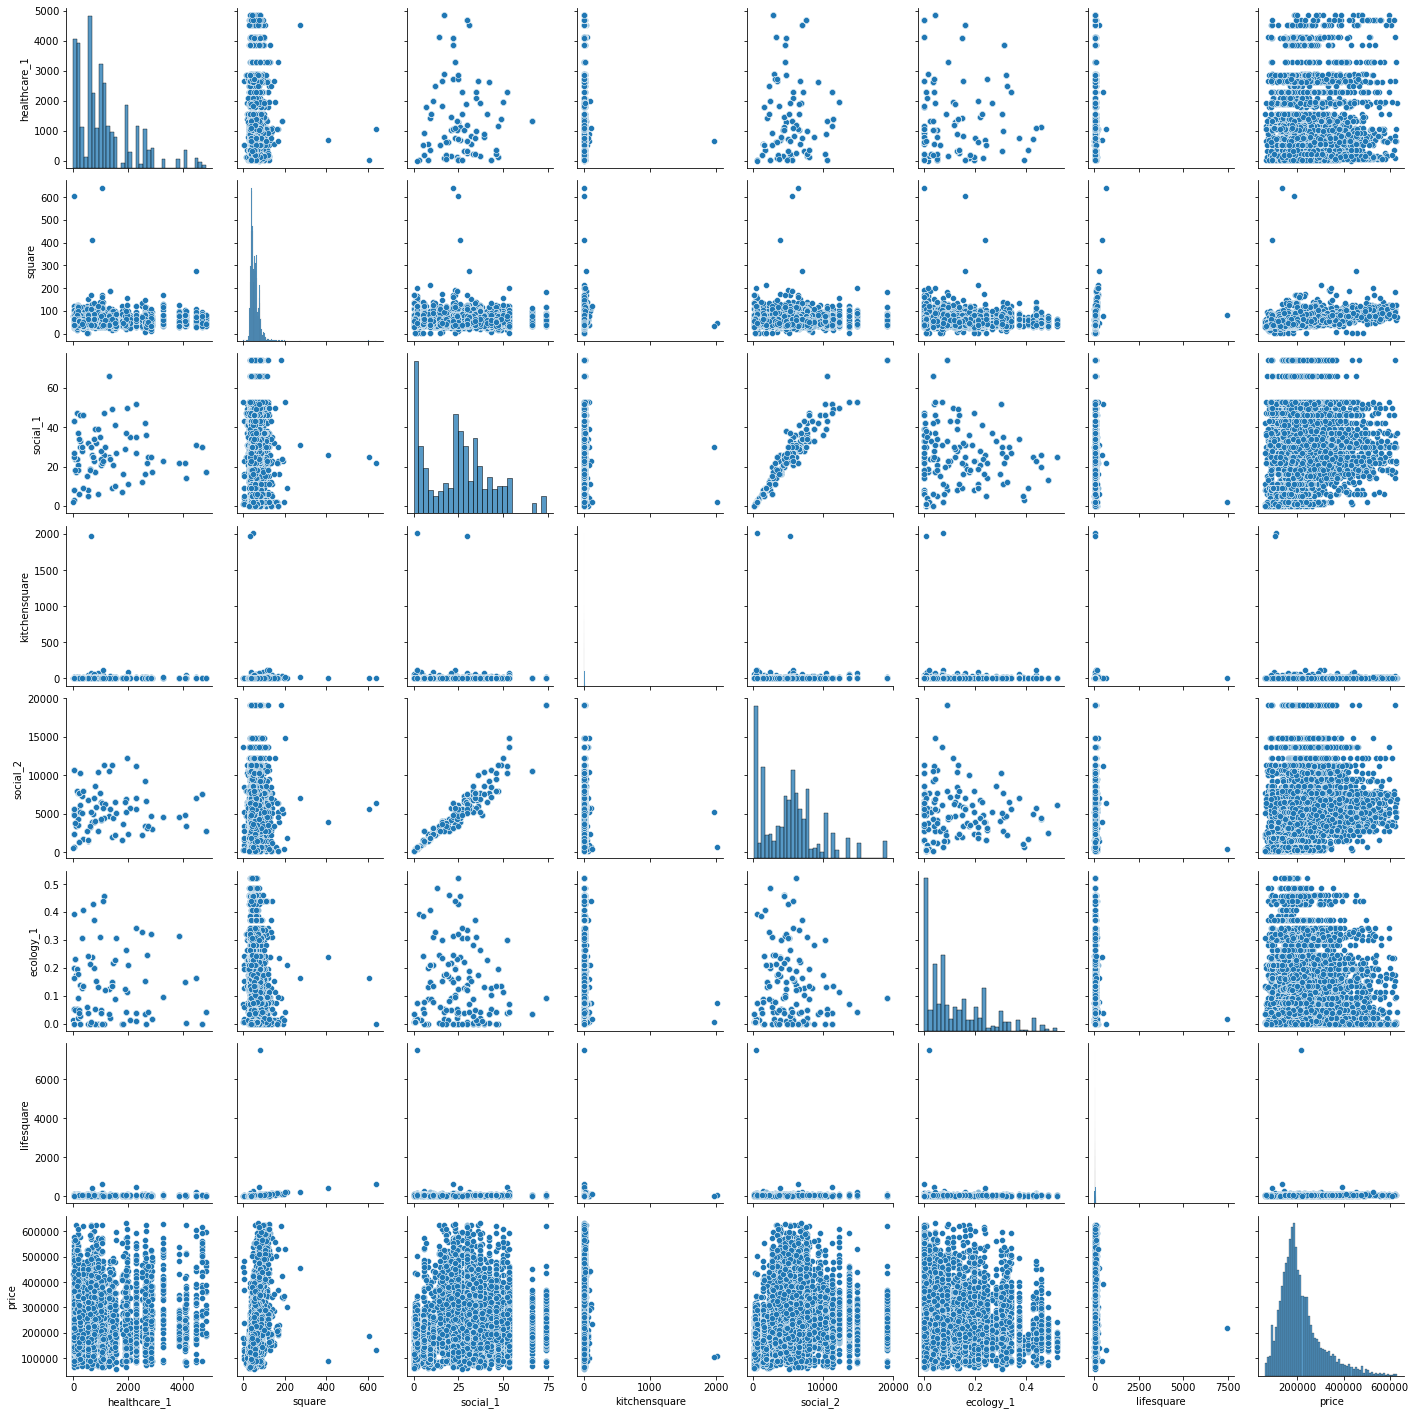

In [28]:
sns.pairplot(train[continuous_feature + [target]]);

### Анализ пропусков

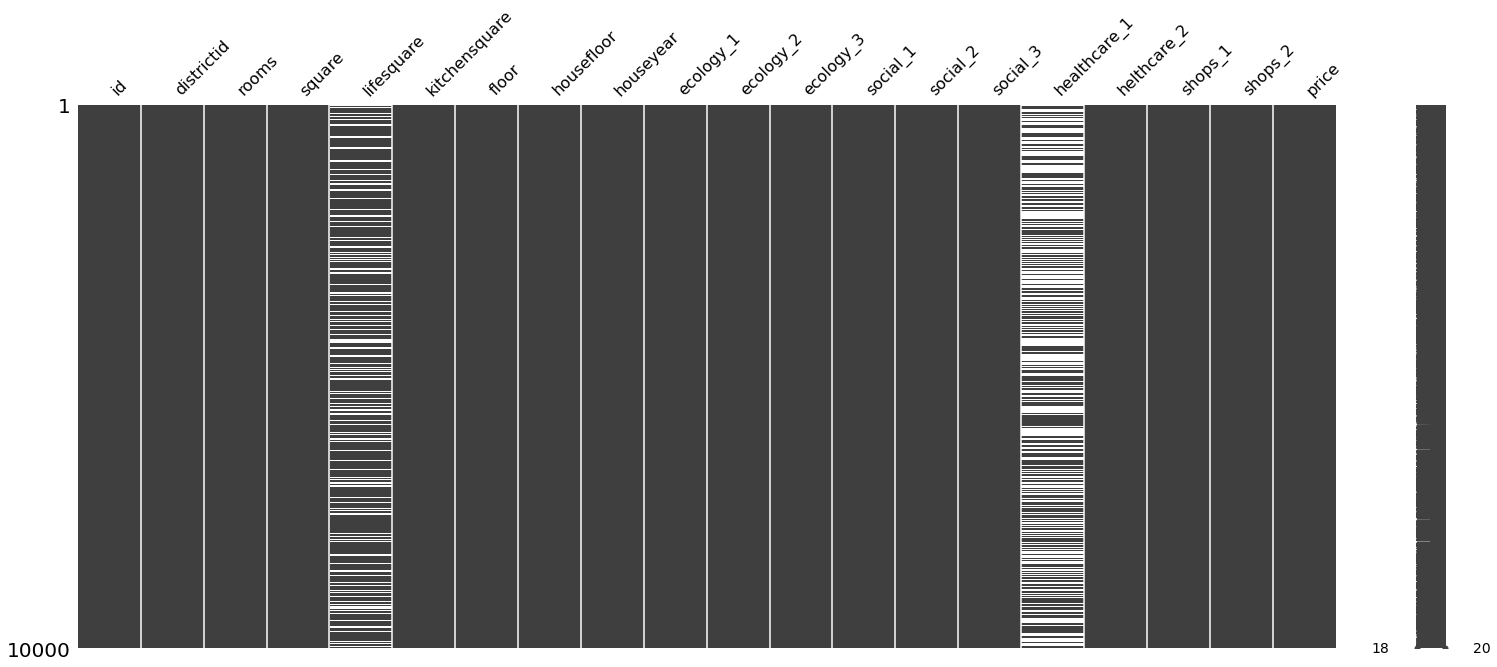

In [30]:
msno.matrix(train);

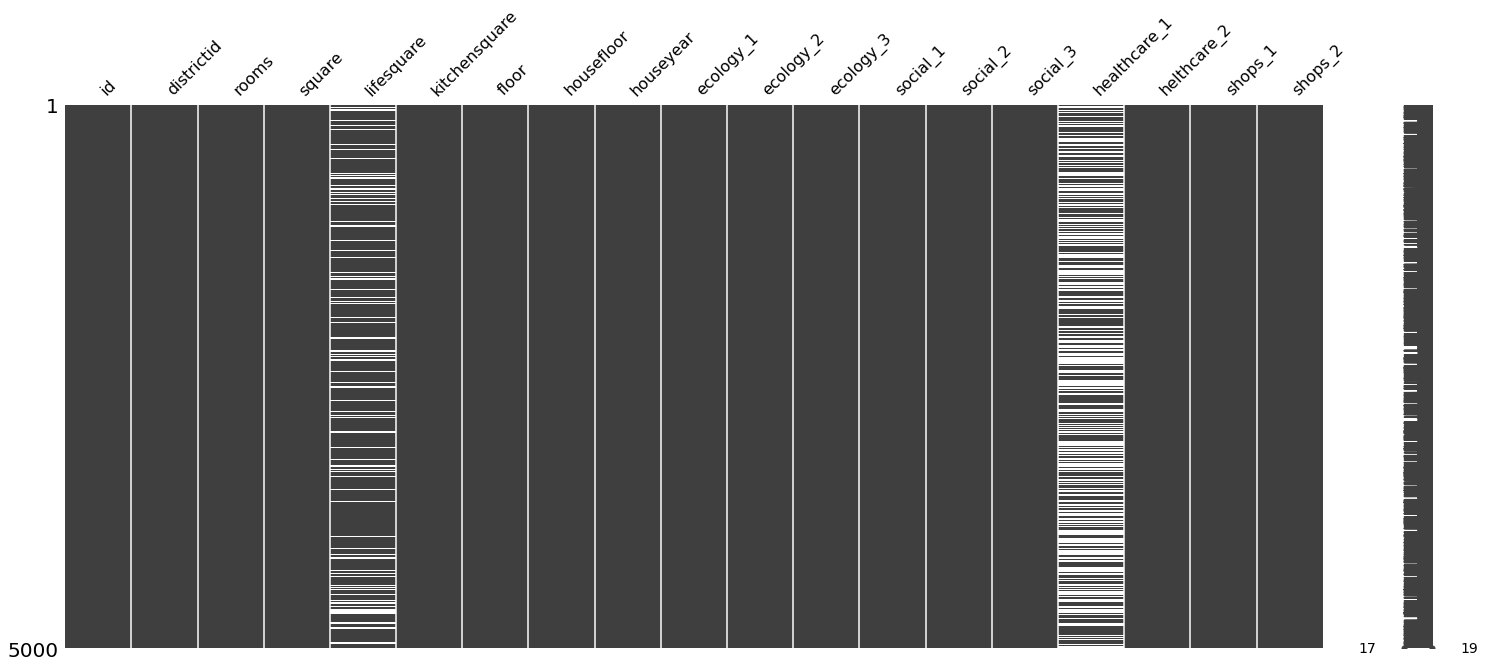

In [31]:
msno.matrix(test);

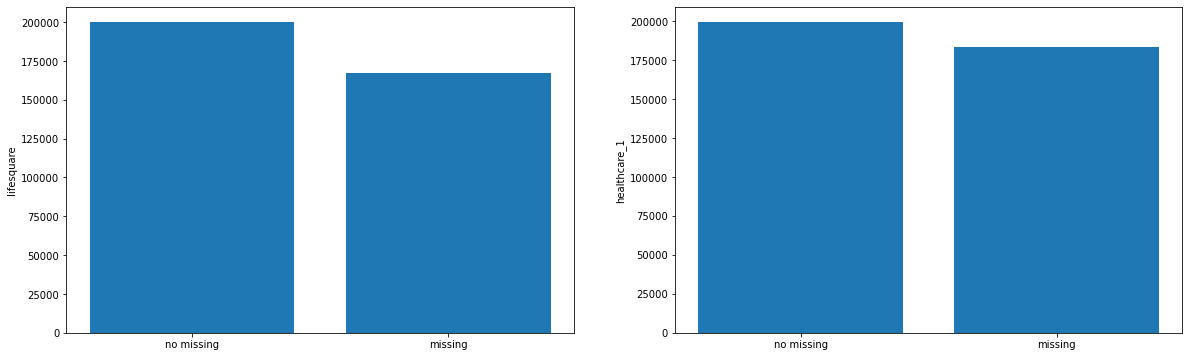

In [32]:
features_with_na = [
    feature for feature in train.columns
    if train[feature].isnull().sum() > 1]

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
for num, feature in enumerate(features_with_na):
    data = train.copy()
    data[feature] = np.where(data[feature].isnull(), 1, 0)
    statistics = data.groupby(feature)["price"].median()
    axes[num//1].bar(statistics.index, statistics.values)
    axes[num//1].set_xticks([0, 1])
    axes[num//1].set_xticklabels(["no missing", "missing"])
    axes[num//1].set_ylabel(feature)

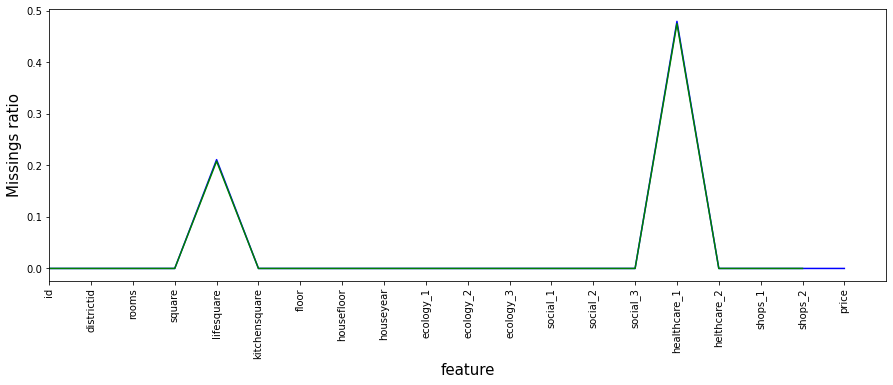

In [33]:
fig = plt.figure(figsize=(15, 5))
plt.plot(train.isnull().mean(), label="train", color="blue")
plt.plot(test.isnull().mean(), label="test", color="green")
plt.xticks(range(train.shape[1]), train.columns, rotation=90)
plt.ylabel("Missings ratio", size=15)
plt.xlabel("feature", size=15)
plt.xlim(0, train.shape[1])
plt.show()

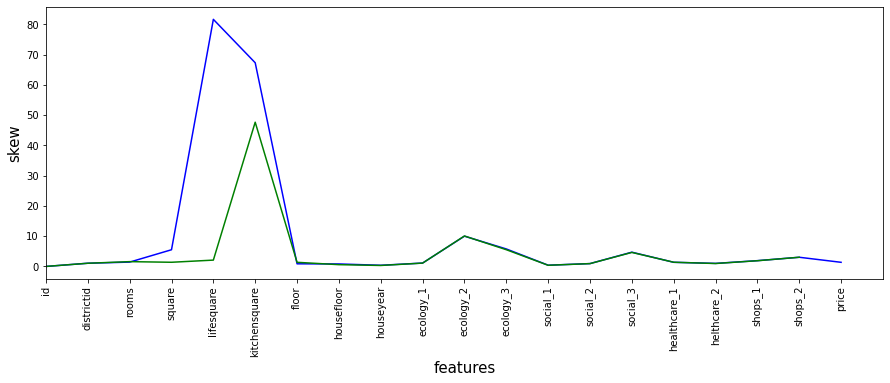

In [34]:
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = train.skew(), test.skew()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.xlim(0, len(train_stats))
plt.ylabel("skew", size=15)
plt.show()

Все признаки, кроме площади, жилой площади, площади кухни, года и social_3 имеют скошенное распределение.

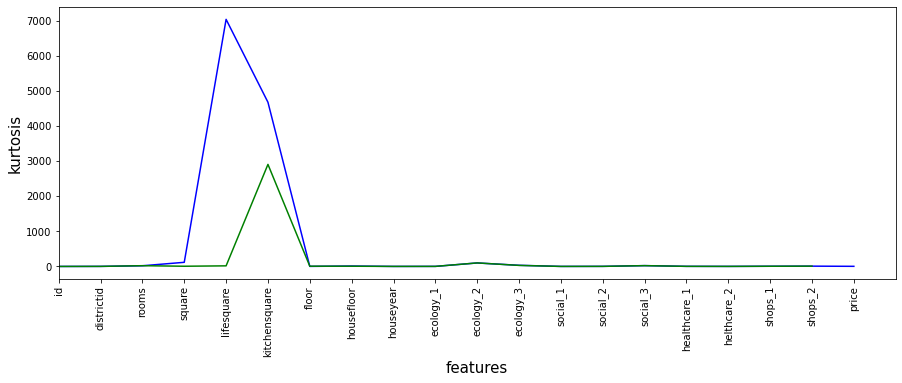

In [35]:
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = train.kurtosis(), test.kurtosis()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.ylabel("kurtosis", size=15)
plt.xlim(0, len(train_stats))
plt.show()

#### Линейные связи

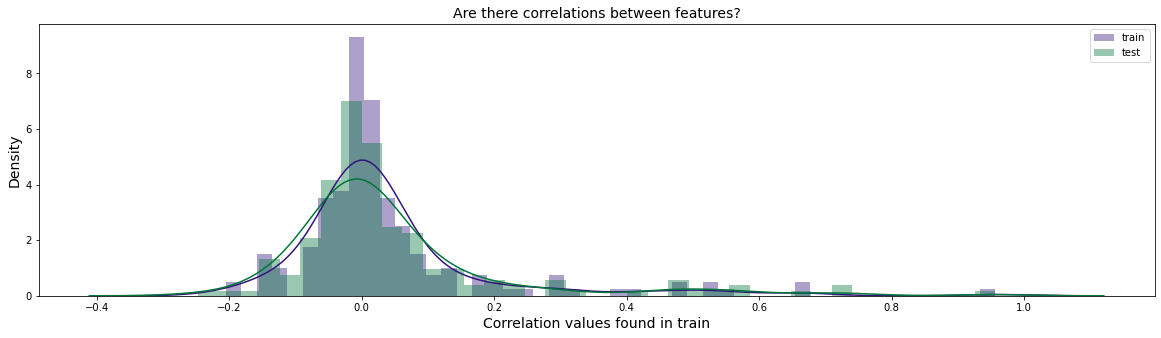

In [36]:
train_correlations = train.drop([target], axis=1).corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="#33137d", label="train")
sns.distplot(test_correlations, color="#007539", label="test")
plt.title("Are there correlations between features?", size=14)
plt.xlabel("Correlation values found in train", size=14)
plt.ylabel("Density", size=14)
plt.legend()
plt.show()

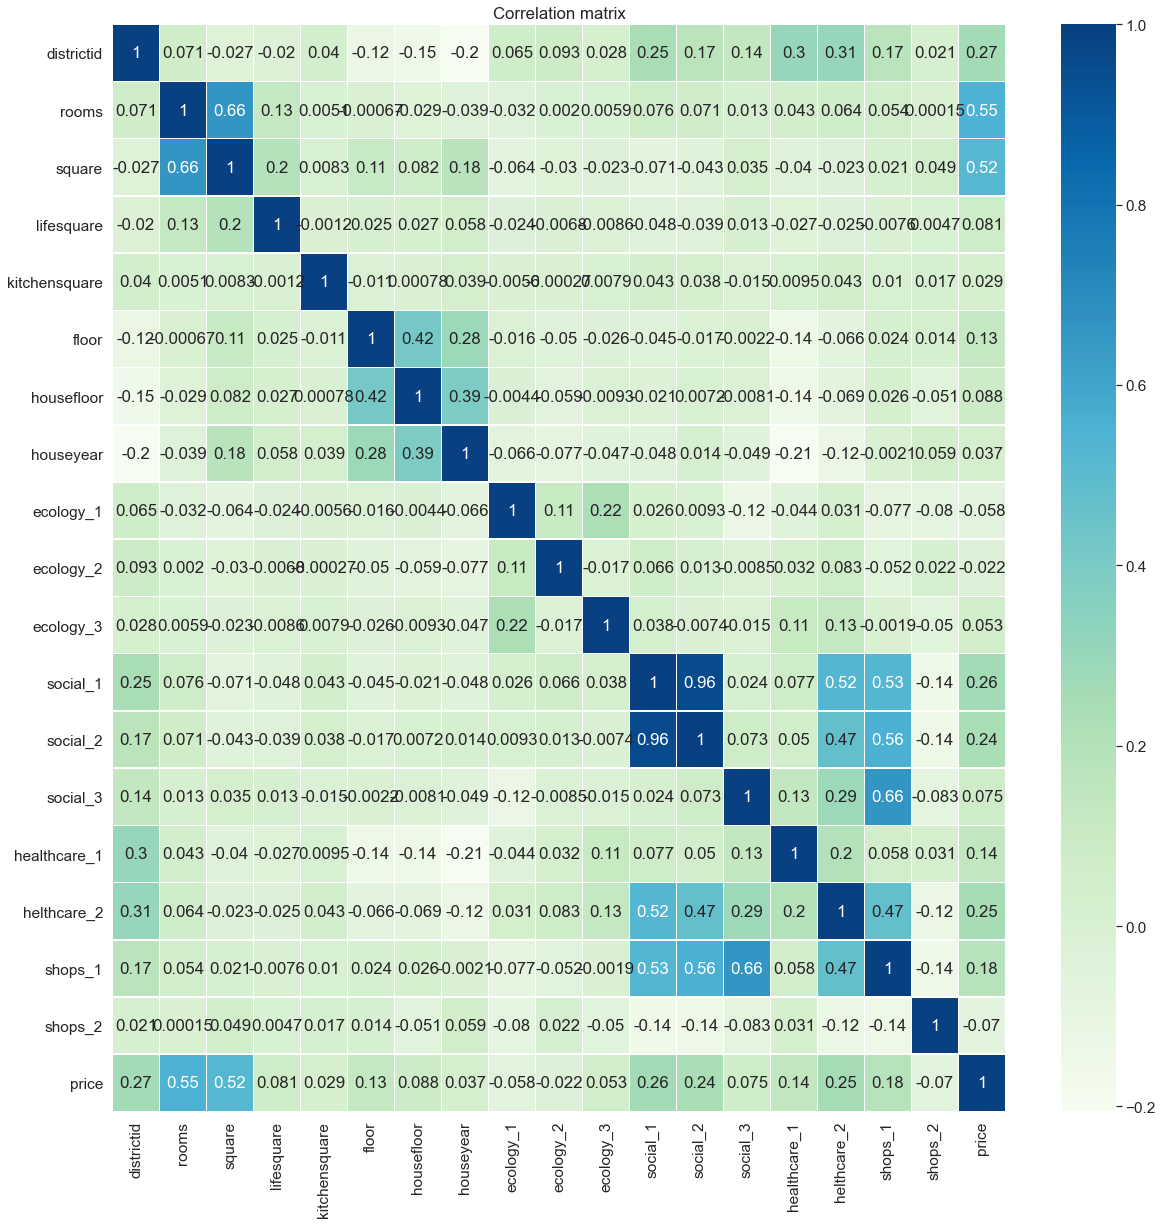

In [37]:
plt.figure(figsize=(20,20))

sns.set(font_scale=1.4)
sns.heatmap(train.drop(columns=['id']).corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Связь между признаками

#### Заполним пропуски и обработаем категориальные признаки

In [38]:
from sklearn.impute import SimpleImputer

si = SimpleImputer()

X_train = train.copy().drop([target], axis=1)
X_train[['lifesquare', 'healthcare_1']] = si.fit_transform(X_train[['lifesquare', 'healthcare_1']])

X_test = test.copy()
X_test[['lifesquare', 'healthcare_1']] = si.transform(X_test[['lifesquare', 'healthcare_1']])

In [39]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

#### Нелинейные связи

In [40]:
parameters = {
    "max_depth": [6, 8, 10, 15],
    "min_samples_leaf": [15, 25, 50, 100, 250]
}

model = RandomForestRegressor(
    n_estimators=100, n_jobs=6, random_state=27
)
grid = GridSearchCV(
    model,
    parameters,
    n_jobs=-1,
    verbose=2,
    cv=3,
)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   13.9s finished


Wall time: 14.8 s


Text(0.5, 1.0, 'What are the top important features to start with?')

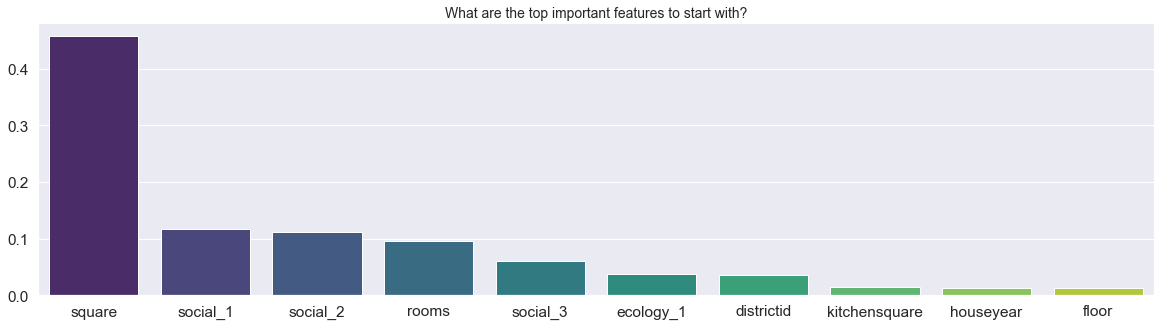

In [41]:
%%time
grid.fit(
    X_train.drop(['id'], axis=1),
    train[target]
)

ntop = 10
importances = grid.best_estimator_.feature_importances_
idx = np.argsort(importances)[::-1][0:ntop]
feature_names = train.drop([target, 'id'], axis=1).columns.values

plt.figure(figsize=(20,5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

### Анализ распределения признаков на обучении и на тесте

In [42]:
x_adv = pd.concat([
    X_train, X_test
])
x_adv = x_adv.reset_index(drop=True)
x_adv = x_adv.drop("id", axis=1)

y_adv = np.hstack((
    np.zeros(X_train.shape[0]),
    np.ones(X_test.shape[0])
))

cv_ = cross_val_score(
    estimator=xgb.XGBClassifier(n_estimators=25),
    X=x_adv, y=y_adv, cv=5, scoring="roc_auc"
)

print(f"CV-mean: {round(np.mean(cv_), 4)} +/- {round(np.std(cv_), 3)}")

CV-mean: 0.4967 +/- 0.005


Распределения признаков похожи.   

### Добавление признаков

In [43]:
# Кластеризуем обучающую и тестовую выборки
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# KMeans требует нормализации данных
scaler = MinMaxScaler()

joined_df = pd.concat([X_train, X_test]).drop(columns='id') # склеиваем трейн и тест
scaler.fit_transform(joined_df)

kmeans = KMeans(n_clusters=20, random_state=27).fit(joined_df)
train['clustering'] = kmeans.labels_[:len(train)]
test['clustering'] = kmeans.labels_[len(train):]

# Добавим среднюю цену по districtid
price_districtid = train.groupby(['districtid']).agg({target: 'median'}).rename(
        columns={'price': 'price_districtid'}).reset_index()

train = train.merge(price_districtid, how='left', on='districtid')
test = test.merge(price_districtid, how='left', on='districtid')

# Добавим среднюю цену по floor
price_floor = train.groupby('floor').agg({target: 'median'}).rename(
        columns={'price': 'price_floor'})

train = train.merge(price_floor, how='left', on='floor')
test = test.merge(price_floor, how='left', on='floor')

# Добавим среднюю цену по rooms
price_rooms = train.groupby('rooms').agg({target: 'median'}).rename(
        columns={'price': 'price_rooms'})

train = train.merge(price_rooms, how='left', on='rooms')
test = test.merge(price_rooms, how='left', on='rooms')

# Рассчитаем среднюю жилую площадь для всех количеств комнат
lifesquare_rooms = train.groupby('rooms').agg({'lifesquare': 'median'}).rename(
        columns={'lifesquare': 'lifesquare_rooms'})

train = train.merge(lifesquare_rooms, how='left', on='rooms')
test = test.merge(lifesquare_rooms, how='left', on='rooms')


### Обработка пропусков

In [44]:
# Пропуски в поле жилая площадь заменим медианой по количеству комнат
def median_lifesquare(train, num_rooms):
    return train.loc[train['rooms'] == num_rooms, 'lifesquare'].median()

for i in range(1, 6):
    train.loc[train['rooms'] == i, 'lifesquare'] = train.loc[
        train['rooms'] == i, 'lifesquare'].fillna(median_lifesquare(train, i))
    
for i in range(1, 6):
    test.loc[test['rooms'] == i, 'lifesquare'] = test.loc[
        test['rooms'] == i, 'lifesquare'].fillna(median_lifesquare(train, i))

# Пропуски в признаке, связанном с инфраструктурой, заменим медианой по району
def median_healthcare(train, districtid):
    return train.loc[train['districtid'] == districtid, 'healthcare_1'].median()

districtid_list = train['districtid'].unique().tolist()

for i in districtid_list:
    train.loc[train['districtid'] == i, 'healthcare_1'] = train.loc[
        train['districtid'] == i, 'healthcare_1'].fillna(median_healthcare(train, i))
    
for i in districtid_list:
    test.loc[test['districtid'] == i, 'healthcare_1'] = test.loc[
        test['districtid'] == i, 'healthcare_1'].fillna(median_healthcare(train, i))

### Обработка датасетов, удаление выбросов, добавление новых признаков

In [45]:
todrop = [target, 'id']

X_train = prepare_dataset(train, todrop)
y_train = train[target]

X_test = prepare_dataset(test, ['id'])

In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 25 columns):
districtid          10000 non-null int32
rooms               10000 non-null int32
square              10000 non-null float64
kitchensquare       10000 non-null float64
floor               10000 non-null float64
housefloor          10000 non-null float64
houseyear           10000 non-null int32
ecology_1           10000 non-null float64
ecology_2           10000 non-null int32
ecology_3           10000 non-null int32
social_1            10000 non-null int64
social_2            10000 non-null int64
social_3            10000 non-null int32
healthcare_1        8116 non-null float64
helthcare_2         10000 non-null int32
shops_1             10000 non-null int32
shops_2             10000 non-null int32
clustering          10000 non-null int32
price_districtid    10000 non-null float64
price_floor         10000 non-null float64
price_rooms         10000 non-null float64
lifesquare_roo

## Обучение модели

In [47]:
cb_params = {
    "n_estimators": 3000,
    "learning_rate": 0.01,
    "loss_function": "RMSE",
    "eval_metric": "R2",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 0,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 27
}

cv = KFold(n_splits=10, random_state=123, shuffle=True)

In [48]:
model = catboost_cross_validation(cb_params, X_train, y_train, cv)

Wed Dec  2 19:06:29 2020, Cross-Validation, 10000 rows, 25 cols
Fold 1, Valid score = 0.7549
Fold 2, Valid score = 0.7705
Fold 3, Valid score = 0.7274
Fold 4, Valid score = 0.7416
Fold 5, Valid score = 0.7453
Fold 6, Valid score = 0.749
Fold 7, Valid score = 0.7657
Fold 8, Valid score = 0.8076
Fold 9, Valid score = 0.7631
Fold 10, Valid score = 0.776
Score by each fold: [0.7549, 0.7705, 0.7274, 0.7416, 0.7453, 0.749, 0.7657, 0.8076, 0.7631, 0.776]
0.7598678341780487


In [49]:
preds = np.zeros(len(X_test))
for model in model[0]:
    preds += model.predict(X_test)

In [50]:
preds = preds / 10

In [51]:
test['price'] = preds
test.loc[:, ['id', 'price']].to_csv('ATaganova_predictions.csv', index=None)